<a href="https://colab.research.google.com/github/PedroAMtz/IA_4_ComputerVision/blob/main/PIA_IA_Versi%C3%B3n_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning and intuitive fine-tuning Convolutional Neural Network model for Brain MRI tumor detection

We directrly connect google colab with kaggle in order to upload de files and datasets we need from there, for this we use the kaggle API and upload it from local device

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


**Importing Libraries**

Finallt we import drive to connect easily with the files we want to load later after training

In [2]:
import os,glob
import cv2
from tqdm.notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
import tensorflow as tf
import pandas as pd 
import progressbar
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image, ImageEnhance
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Enabiling GPU device**

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


**Loading dataset from Kaggle**

In [4]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 86% 13.0M/15.1M [00:01<00:00, 15.3MB/s]
100% 15.1M/15.1M [00:01<00:00, 9.35MB/s]


In [5]:
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"

In [6]:
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Extraction done')

Extraction done


In [7]:
def load_images(folder):    
    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                img = cv2.resize(img, (224,224))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1
    
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [8]:
data, labels = load_images('/content/brain_tumor_dataset')
data.shape, labels.shape

((253, 224, 224, 3), (253,))

**Helper Funtions**

In [9]:
def plot_images(start, end):
    plt.figure(figsize=(20,8))
    for i in range(10):
        axs = plt.subplot(2,5, i+1)
        idx = np.random.randint(start, end)
        plt.imshow(data[idx], cmap='gray')
        plt.axis('off')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        plt.subplots_adjust(wspace=None, hspace=None)

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def confusion_mtx(y_test, y_pred):
  sns.heatmap(confusion_matrix(
  y_test.argmax(axis=1), y_pred.argmax(axis=1)), annot = True, cmap = "rainbow")
  plt.title("Confusion Matrix")
  plt.show()

def plot_image_label(i):
  img, label = data[i], labels[i]
  plt.imshow(img)
  if label==0:
      plt.title("Brain with No Tumor")
  else:
      plt.title("Brain with Tumor")
  plt.show()

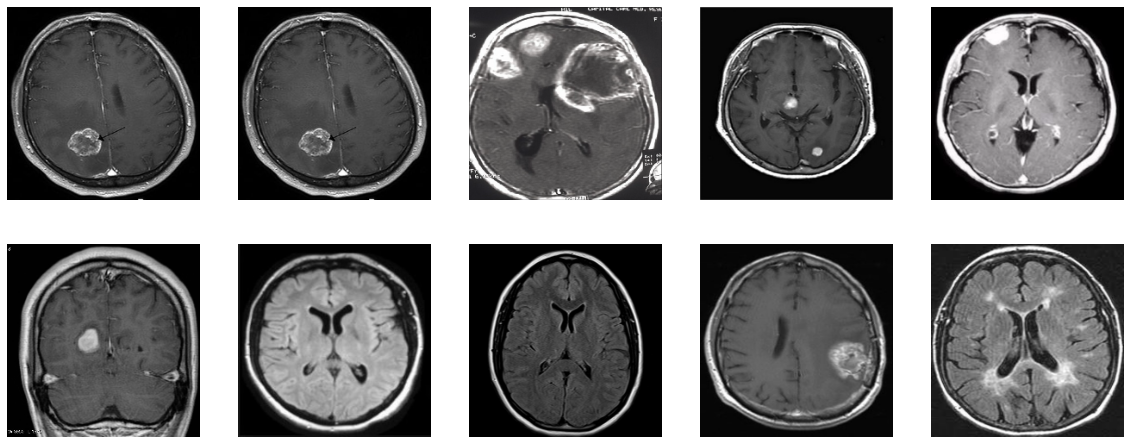

In [ ]:
plot_images(0,253)

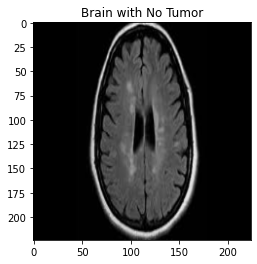

In [ ]:
plot_image_label(10)

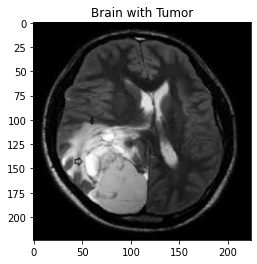

In [ ]:
plot_image_label(200)

**Data normalization and splitting**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test) 

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)
X_train Shape:  (202, 224, 224, 3)
X_test Shape:  (51, 224, 224, 3)
y_train Shape:  (202, 2)
y_test Shape:  (51, 2)


In [11]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
CLASS_NAMES = y_train.shape[1]
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
num_hidden = 32
lrate = 0.001
l1 = 0.
l2 = 0.
regularizer = tf.keras.regularizers.l1_l2(l1, l2)

**Defining our models to use**

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model

In [13]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
CLASS_NAMES = y_train.shape[1]
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

We build a simple CNN model in order to work as a baseline for later tuning

In [ ]:
def build_CNN(num_classes=CLASS_NAMES):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, 7, activation='relu', padding='same',
                            input_shape= IMG_SHAPE),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(num_classes, activation='sigmoid')])
  return model

Creating a callback to save the best model monitored by the validation accuracy

In [ ]:
filepath=["/content/drive/MyDrive/IA_2022/models/Final/weights_SimpleCNN1.best.h5"]
checkpoint1 = ModelCheckpoint(filepath[0], monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list1 = [checkpoint1]

**Models summary**

In [ ]:
build_CNN().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 256)       2

**Compiling the models**


In [ ]:
# EfficientNet
model_1 = build_CNN()
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss= 'binary_crossentropy', metrics= ['accuracy'])


**Training**

In [ ]:
history_1 = model_1.fit(X_train,y_train,
                    epochs=20, 
                    validation_data=(X_test,y_test), 
                    callbacks=callbacks_list1,
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 29.2746 - accuracy: 0.5743
Epoch 1: val_accuracy improved from -inf to 0.47059, saving model to /content/drive/MyDrive/IA_2022/models/Final/weightsM1.best.h5
7/7 [==============================] - 24s 2s/step - loss: 29.2746 - accuracy: 0.5743 - val_loss: 0.7305 - val_accuracy: 0.4706
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.7079
Epoch 2: val_accuracy improved from 0.47059 to 0.70588, saving model to /content/drive/MyDrive/IA_2022/models/Final/weightsM1.best.h5
7/7 [==============================] - 3s 394ms/step - loss: 0.6576 - accuracy: 0.7079 - val_loss: 0.6034 - val_accuracy: 0.7059
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.5666 - accuracy: 0.7475
Epoch 3: val_accuracy did not improve from 0.70588
7/7 [==============================] - 2s 217ms/step - loss: 0.5666 - accuracy: 0.7475 - val_loss: 0.6714 - val_accuracy: 0.7059
Epoch 4/20
7/7 [=====

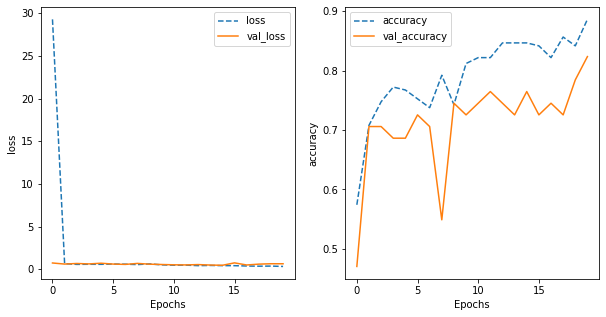

In [ ]:
training_plot(['loss', 'accuracy'], history_1)

In [ ]:
Model_1 = load_model("/content/drive/MyDrive/IA_2022/models/Final/weightsM1.best.h5", compile=True)

In [ ]:
accuracy = Model_1.evaluate(X_test,y_test)
print('Evaluation accuracy of:' , accuracy[1]*100,'%')

2/2 [==============================] - 0s 79ms/step - loss: 0.6395 - accuracy: 0.8235
Evaluation accuracy of: 82.35294222831726 %


In [ ]:
pred_y = (Model_1.predict(X_test) > 0.5).astype("int32")

2/2 [==============================] - 0s 7ms/step


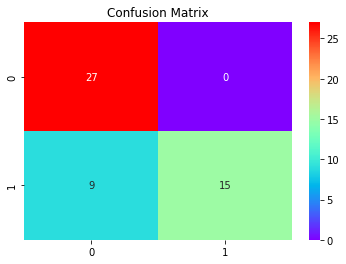

In [ ]:
confusion_mtx(y_test, pred_y)

In [ ]:
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        27
           1       1.00      0.62      0.77        24

   micro avg       0.82      0.82      0.82        51
   macro avg       0.88      0.81      0.81        51
weighted avg       0.87      0.82      0.82        51
 samples avg       0.82      0.82      0.82        51



**Same model but with transfer learning**

For this apporach we use a pretrained model, the EfficientNet load from its weights from imagenet dataset and including only top of our model.
We can observe that the number of trainable parameters decreased and still got a higher validation accuracy.

In [ ]:
def build_TL_CNN(num_classes=CLASS_NAMES):
  base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= IMG_SHAPE, pooling= 'max')
  for layer in base_model.layers:
    layer.trainable = False

  model = tf.keras.models.Sequential([
      base_model,
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(num_classes, activation='sigmoid')])
  return model

In [ ]:
filepath_1=["/content/drive/MyDrive/IA_2022/models/Final/weights_TransferCNN1.best.h5"]
checkpoint2 = ModelCheckpoint(filepath_1[0], monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list2 = [checkpoint1]

In [ ]:
build_TL_CNN().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_15 (Dense)            (None, 128)               196736    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 2)                 130       
                                                                 
Total params: 10,988,657
Trainable params: 205,122
Non

In [ ]:
# EfficientNet
model_2 = build_CNN()
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss= 'binary_crossentropy', metrics= ['accuracy'])

In [ ]:
history_2 = model_2.fit(X_train,y_train,
                    epochs=20, 
                    validation_data=(X_test,y_test), 
                    callbacks=callbacks_list1,
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 24.2298 - accuracy: 0.5842
Epoch 1: val_accuracy improved from -inf to 0.62745, saving model to /content/drive/MyDrive/IA_2022/models/Final/weights_SimpleCNN1.best.h5
7/7 [==============================] - 4s 439ms/step - loss: 24.2298 - accuracy: 0.5842 - val_loss: 0.6516 - val_accuracy: 0.6275
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.7327
Epoch 2: val_accuracy improved from 0.62745 to 0.70588, saving model to /content/drive/MyDrive/IA_2022/models/Final/weights_SimpleCNN1.best.h5
7/7 [==============================] - 3s 404ms/step - loss: 0.6201 - accuracy: 0.7327 - val_loss: 0.5798 - val_accuracy: 0.7059
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.5904 - accuracy: 0.7327
Epoch 3: val_accuracy did not improve from 0.70588
7/7 [==============================] - 2s 227ms/step - loss: 0.5904 - accuracy: 0.7327 - val_loss: 0.5600 - val_accuracy: 0.7059
E

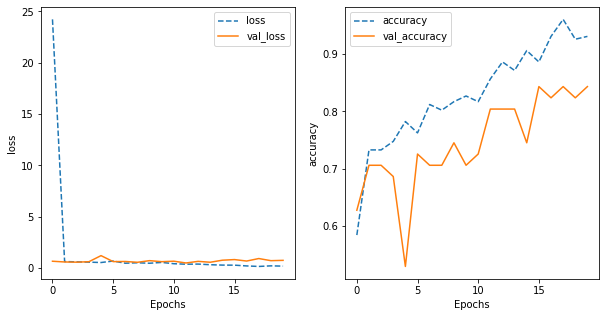

In [ ]:
training_plot(['loss', 'accuracy'], history_2)

In [ ]:
Model_2 = load_model("/content/drive/MyDrive/IA_2022/models/Final/weights_SimpleCNN1.best.h5", compile=True)

In [ ]:
accuracy = Model_2.evaluate(X_test,y_test)
print('Evaluation accuracy of:' , accuracy[1]*100,'%')

2/2 [==============================] - 1s 105ms/step - loss: 0.8129 - accuracy: 0.8431
Evaluation accuracy of: 84.3137264251709 %


In [ ]:
pred_y1 = (Model_2.predict(X_test) > 0.5).astype("int32")

2/2 [==============================] - 0s 102ms/step


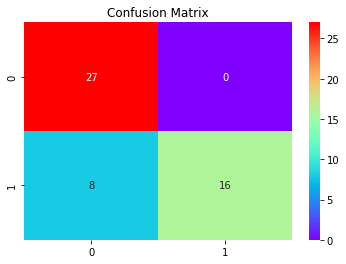

In [ ]:
confusion_mtx(y_test, pred_y1)

In [ ]:
print(classification_report(y_test, pred_y1))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85        27
           1       0.94      0.67      0.78        24

   micro avg       0.82      0.82      0.82        51
   macro avg       0.85      0.81      0.82        51
weighted avg       0.85      0.82      0.82        51
 samples avg       0.81      0.82      0.82        51



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fine-Tuning + Transfer Learning

For this final approach we are going to find the best hyperparameters for the top of our model in order to increase the accuracy.
We use keras tuner.

In [ ]:
pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 8.7 MB/s 
     |████████████████████████████████| 1.6 MB 56.1 MB/s 


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

In [14]:
def build_HPT_model(hp, num_classes=CLASS_NAMES):
  base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= IMG_SHAPE, pooling= 'max')
  for layer in base_model.layers:
    layer.trainable = False

  model = tf.keras.models.Sequential([
      base_model,
      Dense(units=hp.Int('units1', 
                         min_value=32,
                         max_value=512,
                         step=128),
            activation=hp.Choice('act1', ['relu', 'sigmoid'])),
      Dropout(hp.Float('dropout1', 0, 0.5, step=0.1, default=0.5)),
      Dense(units=hp.Int('units2', 
                         min_value=32,
                         max_value=512,
                         step=128),
            activation=hp.Choice('act2', ['relu', 'sigmoid'])),
      Dropout(hp.Float('dropout2', 0, 0.5, step=0.1, default=0.5)),
      Dense(num_classes, hp.Choice('act3', ['softmax', 'sigmoid']))])
  model.compile(optimizer=tf.keras.optimizers.Adam(
      hp.Choice('learning_rate',
                values=[1e-2, 1e-4])),
                loss= 'binary_crossentropy',
                metrics= ['accuracy'])
  return model

In [ ]:
tuner = RandomSearch(
    build_HPT_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=3,
    directory='/content/drive/MyDrive/IA_2022/models/Final/',
    project_name='Model_tuning2'
    )

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 8
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 128, 'sampling': None}
act1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout1 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 128, 'sampling': None}
act2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
dropout2 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
act3 (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_test,y_test))

Trial 15 Complete [00h 02m 30s]
val_accuracy: 0.529411792755127

Best val_accuracy So Far: 0.8169934749603271
Total elapsed time: 00h 34m 45s


In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/IA_2022/models/Final/Model_tuning2
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 160
act1: sigmoid
dropout1: 0.2
units2: 288
act2: relu
dropout2: 0.4
act3: sigmoid
learning_rate: 0.0001
Score: 0.8169934749603271
Trial summary
Hyperparameters:
units1: 160
act1: relu
dropout1: 0.0
units2: 416
act2: sigmoid
dropout2: 0.4
act3: softmax
learning_rate: 0.0001
Score: 0.8169934749603271
Trial summary
Hyperparameters:
units1: 288
act1: sigmoid
dropout1: 0.30000000000000004
units2: 160
act2: sigmoid
dropout2: 0.2
act3: sigmoid
learning_rate: 0.0001
Score: 0.8104575276374817
Trial summary
Hyperparameters:
units1: 288
act1: sigmoid
dropout1: 0.4
units2: 288
act2: relu
dropout2: 0.30000000000000004
act3: softmax
learning_rate: 0.0001
Score: 0.8104575276374817
Trial summary
Hyperparameters:
units1: 160
act1: sigmoid
dropout1: 0.1
units2: 32
act2: sigmoid
dropout2: 0.4
act3: softmax
learning_rate: 0.0001
Score: 0.8039215803146362
Trial

**Building the tuned model based on the tuner trials**

The intuition is to unfreeze the lower layers from EfficientNet model and once we add our fine tuned top model we can increase accuracy and avoid overfitting.

In [15]:
def build_HPT_CNN(num_classes=CLASS_NAMES):
  base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= IMG_SHAPE, pooling= 'max')

  model = tf.keras.models.Sequential([
      base_model,
      tf.keras.layers.Dense(160, activation='sigmoid'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(288, activation='relu'),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(num_classes, activation='sigmoid')])
  return model

In [16]:
checkpoint2 = ModelCheckpoint("/content/drive/MyDrive/IA_2022/models/Final/weights_HPT1.best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list2 = [checkpoint2]

In [17]:
model_3 = build_HPT_CNN()
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss= 'binary_crossentropy', metrics= ['accuracy'])

43941136/43941136 [==============================] - 3s 0us/step


In [18]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense (Dense)               (None, 160)               245920    
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 288)               46368     
                                                                 
 dropout_1 (Dropout)         (None, 288)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 578       
                                                                 
Total params: 11,076,401
Trainable params: 10,989,098
No

In [19]:
history_3 = model_3.fit(X_train,y_train,
                    epochs=20, 
                    validation_data=(X_test,y_test), 
                    callbacks=callbacks_list2)

Epoch 1/20
7/7 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.6040
Epoch 1: val_accuracy improved from -inf to 0.52941, saving model to /content/drive/MyDrive/IA_2022/models/Final/weights_HPT1.best.h5
7/7 [==============================] - 39s 2s/step - loss: 0.6784 - accuracy: 0.6040 - val_loss: 0.7271 - val_accuracy: 0.5294
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 0.6309 - accuracy: 0.6485
Epoch 2: val_accuracy did not improve from 0.52941
7/7 [==============================] - 4s 526ms/step - loss: 0.6309 - accuracy: 0.6485 - val_loss: 0.6988 - val_accuracy: 0.5294
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 0.5244 - accuracy: 0.7327
Epoch 3: val_accuracy improved from 0.52941 to 0.66667, saving model to /content/drive/MyDrive/IA_2022/models/Final/weights_HPT1.best.h5
7/7 [==============================] - 5s 797ms/step - loss: 0.5244 - accuracy: 0.7327 - val_loss: 0.6359 - val_accuracy: 0.6667
Epoch 4/20
7/7 [=

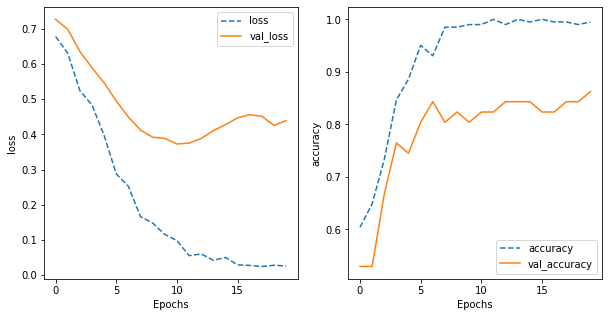

In [20]:
training_plot(['loss', 'accuracy'], history_3)

In [21]:
Model_3 = load_model("/content/drive/MyDrive/IA_2022/models/Final/weights_HPT1.best.h5", compile=True)

In [22]:
accuracy = Model_3.evaluate(X_test,y_test)
print('Evaluation accuracy of:' , accuracy[1]*100,'%')

2/2 [==============================] - 2s 86ms/step - loss: 0.4395 - accuracy: 0.8627
Evaluation accuracy of: 86.27451062202454 %


2/2 [==============================] - 4s 149ms/step


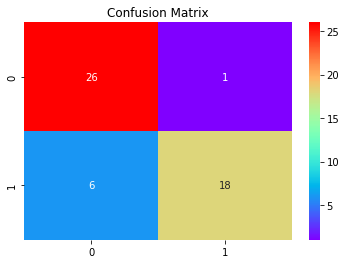

In [24]:
pred_y2 = (Model_3.predict(X_test) > 0.5).astype("int32")
confusion_mtx(y_test, pred_y2)

In [25]:
print(classification_report(y_test, pred_y2))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        27
           1       0.95      0.75      0.84        24

   micro avg       0.86      0.86      0.86        51
   macro avg       0.88      0.86      0.86        51
weighted avg       0.88      0.86      0.86        51
 samples avg       0.86      0.86      0.86        51



# Results

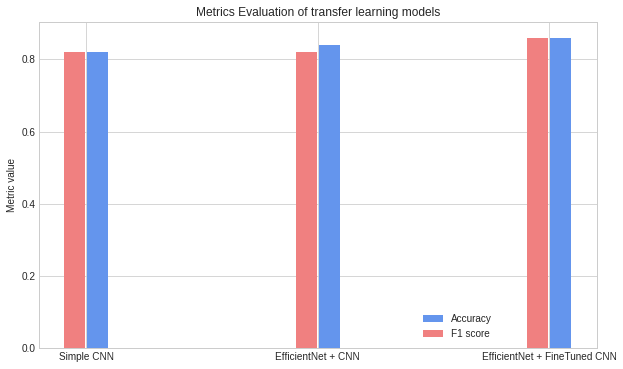

In [43]:
mean_accuracy = [0.82, 0.84, 0.86]
mean_f1score = [0.82 ,0.82, 0.86]
models = ['Simple CNN', 'EfficientNet + CNN', 'EfficientNet + FineTuned CNN']
y_pos = np.arange(len(mean_accuracy))
y_pos

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))
plt.xticks(y_pos, models)
plt.title('Metrics Evaluation of transfer learning models')
plt.ylabel('Metric value')
plt.bar(y_pos+0.05, mean_accuracy[:], width=0.09, label='Accuracy', color='cornflowerblue')
plt.bar(y_pos-0.05, mean_f1score[:], width=0.09, label='F1 score', color='Lightcoral')
plt.legend(loc = 'best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.show();